# Introducción al Proyecto
Este proyecto se enfoca en el análisis y modelado de la serie temporal de la profundidad al agua subterránea en la región de SAL utilizando técnicas estadísticas avanzadas y aprendizaje profundo. El objetivo principal es desarrollar un modelo predictivo robusto que pueda capturar la dinámica temporal y prever futuros cambios en la profundidad del agua subterránea, lo cual es crucial para la gestión de recursos hídricos y la planificación ambiental.

## Etapas del Proyecto:
### Análisis Exploratorio de Datos (EDA): 
Se realiza un examen inicial de los datos para entender sus características fundamentales, incluyendo la distribución, la presencia de valores faltantes y la identificación de posibles outliers. Este paso es fundamental para asegurar la calidad de los datos antes de proceder al modelado.

### Modelado SARIMAX: 
Se aplica un modelo SARIMAX para capturar tanto las tendencias y estacionalidades de la serie temporal como efectos de variables exógenas que podrían influir en la profundidad al agua subterránea. Este modelo ayuda a entender los factores que influyen en las fluctuaciones observadas y a hacer predicciones a corto plazo.

### Modelado con Redes LSTM: 
Debido a la capacidad de las redes LSTM para manejar dependencias a largo plazo, se desarrolla un modelo LSTM para prever la profundidad al agua subterránea. Este enfoque se centra en capturar la dinámica compleja y no lineal que los modelos más tradicionales podrían no detectar eficazmente.
Evaluación de Modelos: Se comparan los modelos en términos de su precisión y capacidad para prever cambios futuros, utilizando métricas de error estándar y visualización de predicciones frente a los valores reales.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import itertools
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import os
from keras.models import load_model
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# EDA Acuífero Auser

In [2]:
df_auser = pd.read_csv('../data/raw/Aquifer_Auser.csv')

# Mostrar las primeras filas del DataFrame
print(df_auser.head())

         Date  Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
0  05/03/1998                 NaN                  NaN                   NaN   
1  06/03/1998                 NaN                  NaN                   NaN   
2  07/03/1998                 NaN                  NaN                   NaN   
3  08/03/1998                 NaN                  NaN                   NaN   
4  09/03/1998                 NaN                  NaN                   NaN   

   Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
0                NaN                       NaN                 NaN   
1                NaN                       NaN                 NaN   
2                NaN                       NaN                 NaN   
3                NaN                       NaN                 NaN   
4                NaN                       NaN                 NaN   

   Rainfall_Calavorno  Rainfall_Croce_Arcana  \
0                 NaN                    NaN   
1 

In [3]:
# Descripción estadística del conjunto de datos
print(df_auser.describe())

       Rainfall_Gallicano  Rainfall_Pontetetto  Rainfall_Monte_Serra  \
count         5295.000000          5295.000000           5289.000000   
mean             4.948782             3.495449              3.919077   
std             14.366480             9.983772             10.815270   
min              0.000000             0.000000              0.000000   
25%              0.000000             0.000000              0.000000   
50%              0.000000             0.000000              0.000000   
75%              2.000000             1.000000              1.600000   
max            318.800000           146.600000            152.200000   

       Rainfall_Orentano  Rainfall_Borgo_a_Mozzano  Rainfall_Piaggione  \
count        5295.000000               5295.000000         4930.000000   
mean            3.150670                  4.578961            3.953976   
std             8.747507                 12.771166           10.888103   
min             0.000000                  0.000000     

In [4]:
# Información del DataFrame para entender tipos de datos y valores faltantes
print(df_auser.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

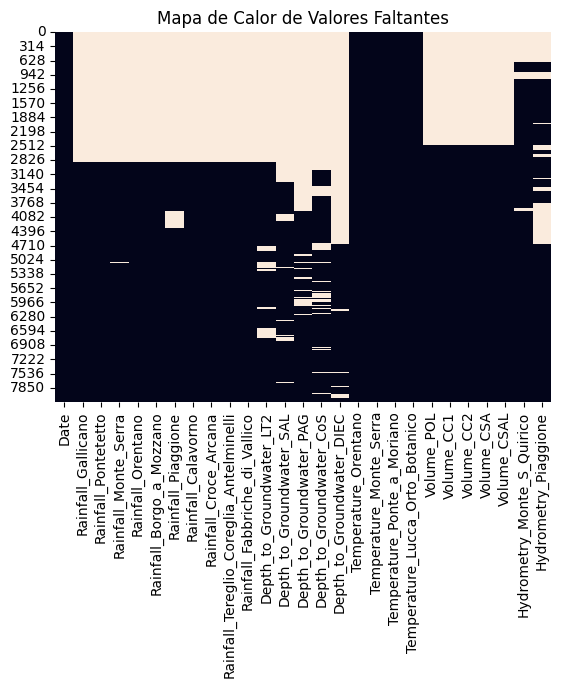

In [5]:
# Gráfico de los valores faltantes
sns.heatmap(df_auser.isnull(), cbar=False)
plt.title('Mapa de Calor de Valores Faltantes')
plt.show()

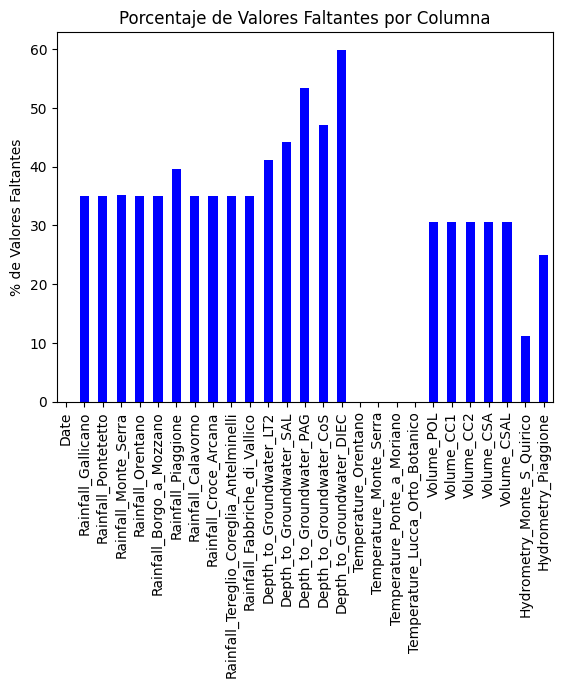

In [6]:
# Porcentaje de valores faltantes por columna
missing_percentage = df_auser.isnull().mean() * 100
missing_percentage.plot.bar(color='blue')
plt.title('Porcentaje de Valores Faltantes por Columna')
plt.ylabel('% de Valores Faltantes')
plt.show()

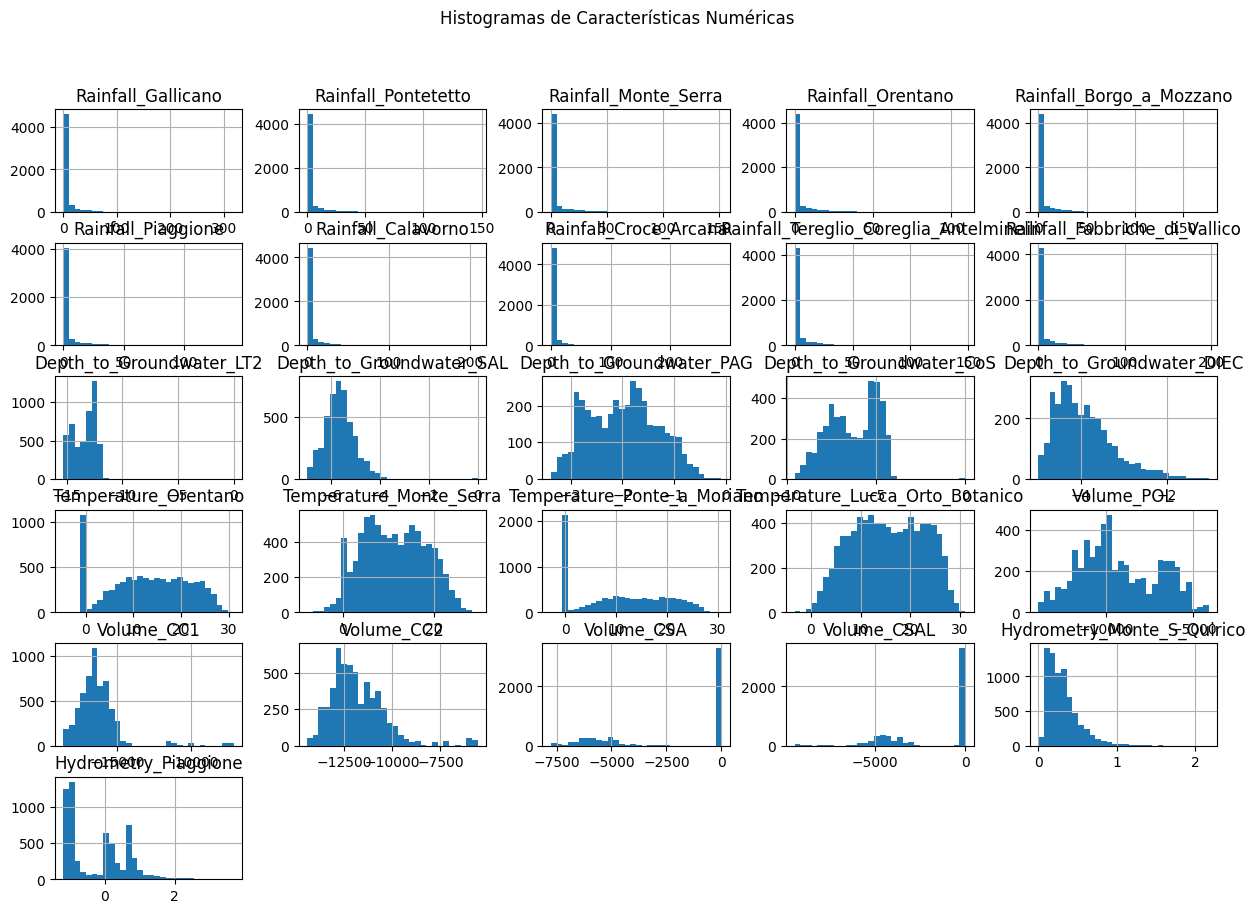

In [7]:
# Histogramas de todas las características numéricas
df_auser.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histogramas de Características Numéricas')
plt.show()

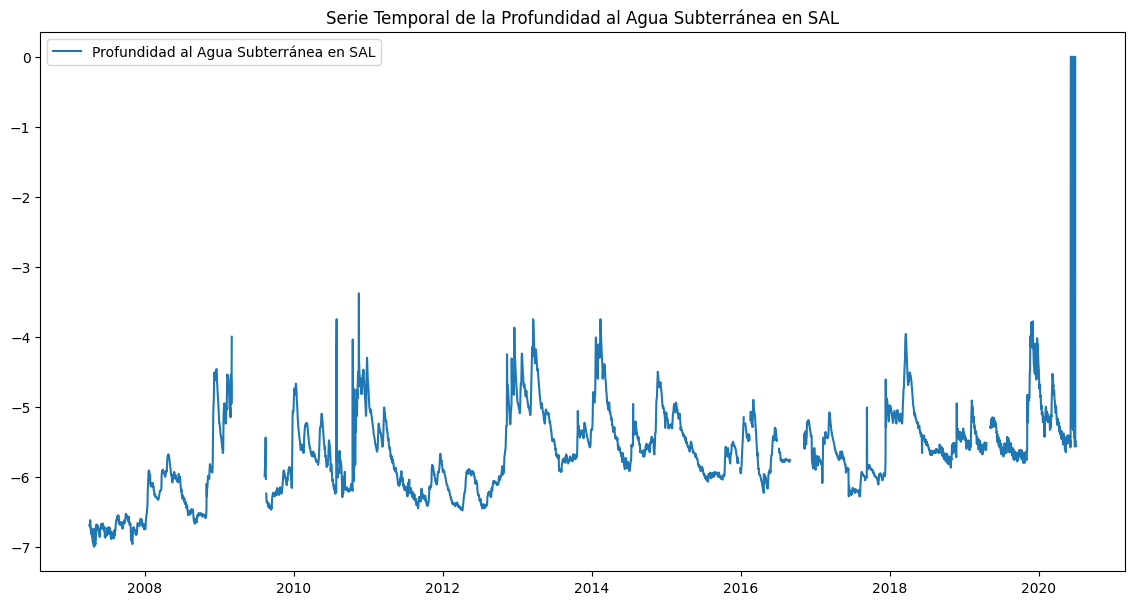

In [8]:
# Convertir la columna 'Date' a datetime especificando el formato correcto
df_auser['Date'] = pd.to_datetime(df_auser['Date'], format='%d/%m/%Y')

# Establecer la columna 'Date' como índice del DataFrame
df_auser.set_index('Date', inplace=True)

# Serie temporal de una característica como la profundidad al agua subterránea
plt.figure(figsize=(14, 7))
plt.plot(df_auser['Depth_to_Groundwater_SAL'], label='Profundidad al Agua Subterránea en SAL')
plt.title('Serie Temporal de la Profundidad al Agua Subterránea en SAL')
plt.legend()
plt.show()

### Pasos a seguir para la limpieza de datos
+ Eliminación de Filas con Excesivos Valores Faltantes

+ Imputación de Datos Faltantes en las Filas Restantes

+ Tratamiento del Valor Atípico (final de la serie temporal)

In [9]:
# Imputación de valores faltantes usando KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_numeric = df_auser.select_dtypes(include=[np.number])
df_auser[df_numeric.columns] = imputer.fit_transform(df_numeric)


In [10]:
# Detección y manejo de valores atípicos usando z-scores
z_scores = np.abs(stats.zscore(df_auser.select_dtypes(include=[np.number])))
df_auser = df_auser[(z_scores < 3).all(axis=1)]


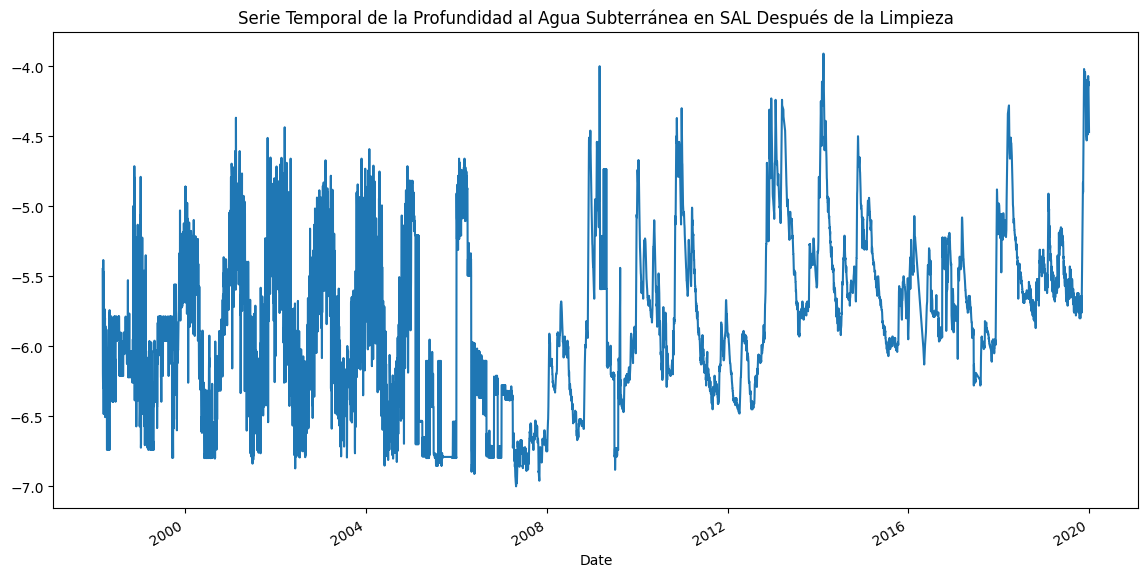

In [11]:
df_auser['Depth_to_Groundwater_SAL'].plot(figsize=(14, 7))
plt.title('Serie Temporal de la Profundidad al Agua Subterránea en SAL Después de la Limpieza')
plt.show()

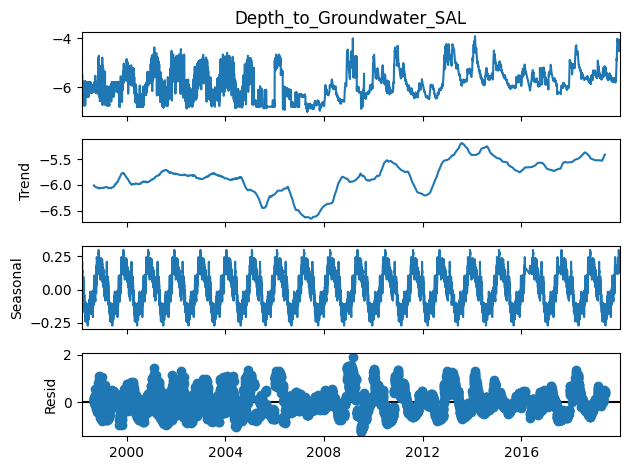

In [12]:
# Descomposición de la serie temporal
decomposition = sm.tsa.seasonal_decompose(df_auser['Depth_to_Groundwater_SAL'], model='additive', period=365)
decomposition.plot()
plt.show()

## Análisis
La descomposición de la serie temporal muestra claramente la tendencia y la estacionalidad en los datos de profundidad del agua subterránea en el acuífero SAL. La tendencia muestra cómo cambia el nivel del agua a lo largo del tiempo, mientras que el componente estacional muestra patrones que se repiten en intervalos regulares, probablemente relacionados con las estaciones del año y los patrones climáticos.

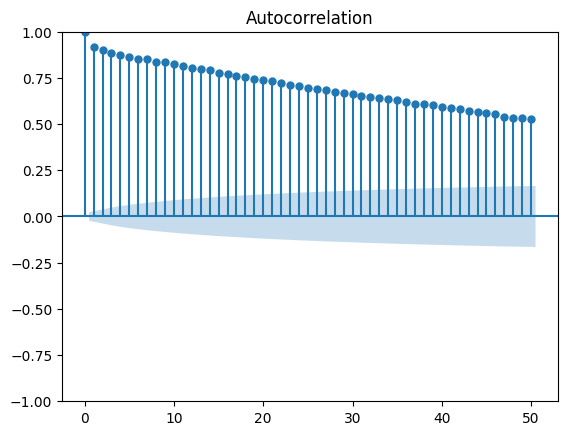

In [13]:
# Correlograma para ver la autocorrelación
plot_acf(df_auser['Depth_to_Groundwater_SAL'].dropna(), lags=50)
plt.show()

## Análisis
El correlograma indica una fuerte autocorrelación en los primeros rezagos, que disminuye gradualmente pero se mantiene positiva a medida que aumentan los rezagos. Esto es típico de una serie temporal que tiene tanto tendencia como estacionalidad.

La autocorrelación positiva significativa en los primeros rezagos sugiere que los valores pasados ​​tienen una influencia fuerte en los valores futuros, lo cual es característico de los datos hidrológicos, donde las mediciones de un día pueden ser similares a las mediciones de días cercanos debido a la inercia en el sistema hidrológico.

La disminución gradual de la autocorrelación indica que la influencia de los valores pasados ​​disminuye a medida que el intervalo de tiempo aumenta. La persistencia de la autocorrelación positiva hasta rezagos más altos puede ser un signo de estacionalidad, lo que significa que los patrones de la serie temporal se repiten después de un cierto número de periodos.

In [14]:
# Prueba de Dickey-Fuller aumentada para verificar la estacionariedad
adf_result = sm.tsa.stattools.adfuller(df_auser['Depth_to_Groundwater_SAL'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -5.3648513196618115
p-value: 4.01318096758723e-06


## Análisis
El resultado de la prueba ADF sugiere que la serie temporal es estacionaria, ya que el valor p es menor que 0.05, lo que permite rechazar la hipótesis nula de que la serie tiene una raíz unitaria.

### Decisión
Vamos a entrenar un modelo SARIMA, identificando previamente p, q y d

In [17]:
# Dividir los datos en conjunto de entrenamiento y prueba
split_point = int(len(df_auser) * 0.8)  # 80% para entrenamiento, 20% para prueba
train = df_auser.iloc[:split_point]
test = df_auser.iloc[split_point:]

y_train = train['Depth_to_Groundwater_SAL']
y_test = test['Depth_to_Groundwater_SAL']

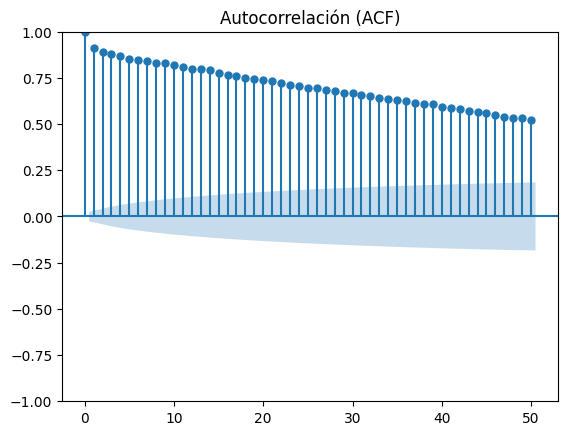

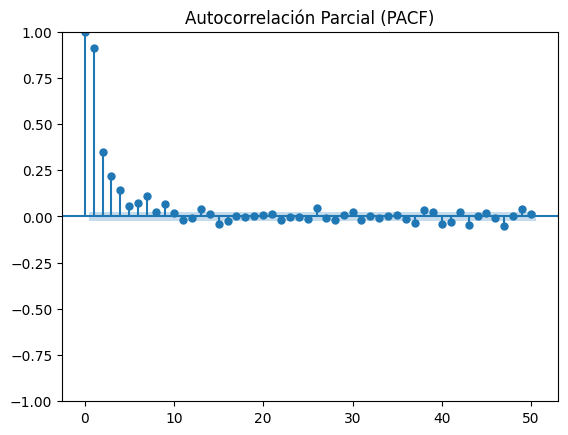

In [18]:
# Graficamos para estimar los mejores p y q
plot_acf(y_train, lags=50)
plt.title('Autocorrelación (ACF)')
plt.show()

plot_pacf(y_train, lags=50)
plt.title('Autocorrelación Parcial (PACF)')
plt.show()

## Interpretación del gráfico PACF:
Decaimiento Rápido: Las barras en los primeros lags y luego un decaimiento rápido sugieren la presencia de un componente autoregresivo.
Lags Significativos: El primer lag que es significativamente diferente de cero sugiere un buen punto de partida para el parámetro 
𝑝. El primer lag y posiblemente el segundo son significativos, ya que están bastante por encima del área de significancia (las líneas horizontales azules).


In [19]:
result = adfuller(y_train.dropna()) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print("La serie no es estacionaria y podría necesitar diferenciación.")
else:
    print("La serie es estacionaria.")

ADF Statistic: -5.278833
p-value: 0.000006
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
La serie es estacionaria.


Por lo que d=0

Mejor SARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:-935.2291265910123


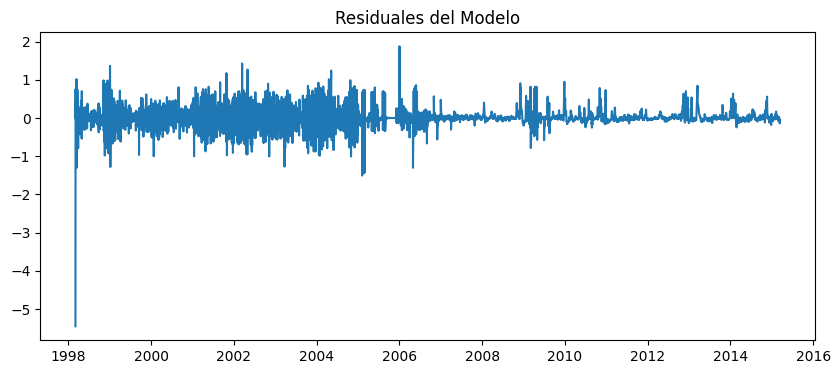

In [20]:
# Suprimir warnings para evitar saturación visual durante la optimización
warnings.filterwarnings("ignore")

# Configuración de los rangos de parámetros SARIMA con seasonal_periods = 12
p = range(0, 3)  # Explorar valores para AR
d = range(0, 2)  # Explorar valores para I, incluyendo no diferenciación y una diferenciación
q = range(0, 3)  # Explorar valores para MA
seasonal_periods = 12  # Estacionalidad anual supuesta
D = range(0, 2)  # Explorar diferenciación estacional

# Generar todas las combinaciones de configuraciones SARIMA
pdq = [(x[0], x[1], x[2]) for x in itertools.product(p, d, q)]
seasonal_pdq = [(x[0], x[1], x[2], seasonal_periods) for x in itertools.product(p, D, q)]

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Bucle para probar cada combinación de parámetros
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit(maxiter=100, method='powell', disp=False)  # Ajustar usando Powell y limitar iteraciones
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except Exception as e:
            print(f"Error with parameters {param}x{param_seasonal}: {e}")

# Mostrar los mejores resultados
print(f"Mejor SARIMA{best_pdq}x{best_seasonal_pdq}12 - AIC:{best_aic}")

# Diagnóstico de residuos para verificar si son aproximadamente ruido blanco
if best_model:
    residuals = best_model.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title('Residuales del Modelo')
    plt.show()

## Interpretación de los Residuales
Homogeneidad: La homogeneidad en los residuales, sin patrones claros o tendencias, es generalmente un buen indicador. Esto sugiere que el modelo ha capturado la mayor parte de la estructura de los datos.
Picos: Los picos o fluctuaciones significativas pueden indicar la presencia de outliers o eventos no captados por el modelo. Estos pueden necesitar un manejo especial, como modelos adicionales o ajustes a los datos (e.g., remoción o ajuste de outliers).

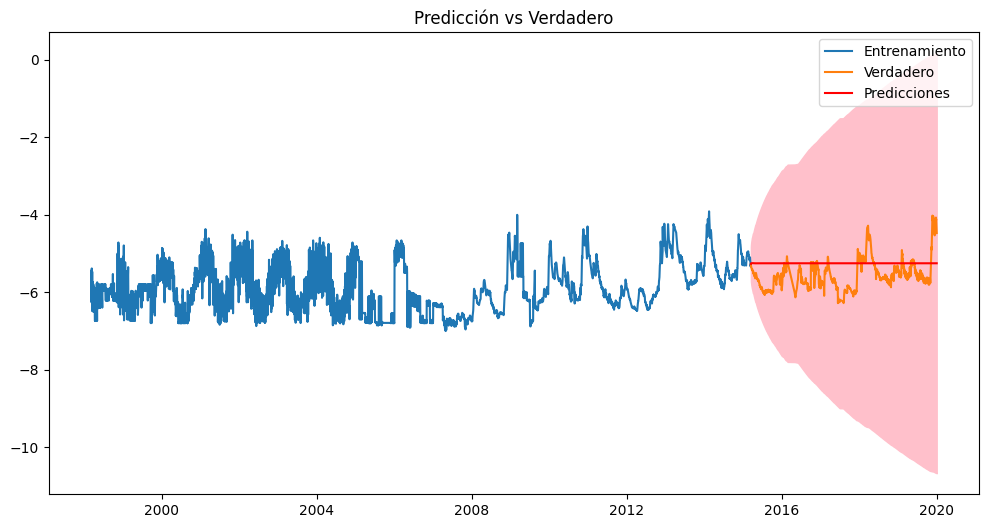

In [22]:
# Predicción en el conjunto de prueba
predictions = best_model.get_forecast(steps=len(y_test))
predicted_mean = predictions.predicted_mean
conf_int = predictions.conf_int()

# Visualización de las predicciones vs los verdaderos
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Entrenamiento')
plt.plot(y_test.index, y_test, label='Verdadero')
plt.plot(y_test.index, predicted_mean, label='Predicciones', color='r')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.title('Predicción vs Verdadero')
plt.legend()
plt.show()

## Análisis del Problema
Estabilidad de las Predicciones: El modelo parece tener una tendencia a predecir valores que no se ajustan a las fluctuaciones observadas en los datos verdaderos. Esto puede deberse a varios factores:
Inadecuada captura de la estacionalidad: Aunque el modelo incorpora componentes estacionales, estos no pueden ser suficientes o adecuados para describir los patrones en los datos.
Posible subajuste (underfitting): El modelo puede ser demasiado simple comparado con la complejidad de los datos, resultando en incapacidad para captar la dinámica subyacente.
Poca Reactividad a Cambios Recientes: Las predicciones no parecen reaccionar a los cambios más recientes en los datos, lo que podría indicar que el modelo necesita ser más sensible a la información más reciente, quizás a través de un enfoque de modelado diferente o ajustando cómo se modelan las tendencias y la estacionalidad.

In [30]:
# Crear el directorio si no existe
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Nombre del archivo del modelo
model_filename = os.path.join(model_dir, 'SARIMAX_best_model.pkl')

# Guardar el modelo
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f'Modelo guardado en: {model_filename}')

NameError: name 'best_model' is not defined

Vamos a trabajar en una red LSTM

In [15]:
# Normalización
scaler = MinMaxScaler()
df_auser_scaled = scaler.fit_transform(df_auser)
df_auser_scaled = pd.DataFrame(df_auser_scaled, columns=df_auser.columns, index=df_auser.index)

In [16]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 13

# Preparar 'train' y 'test' correctamente desde 'df_auser_scaled'
train_scaled = df_auser_scaled[:int(len(df_auser_scaled)*0.8)]  # Asumiendo 80% para entrenamiento
test_scaled = df_auser_scaled[int(len(df_auser_scaled)*0.8):]  # 20% para test

# Seleccionar todas las características excepto la variable objetivo
features = [col for col in df_auser_scaled.columns if col != 'Depth_to_Groundwater_SAL']

# Preparar datos para el entrenamiento y la prueba
X_train, y_train = create_dataset(train_scaled[features], train_scaled['Depth_to_Groundwater_SAL'], time_steps)
X_test, y_test = create_dataset(test_scaled[features], test_scaled['Depth_to_Groundwater_SAL'], time_steps)

In [18]:
# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # La capa de salida predice el siguiente valor de 'Depth_to_Groundwater_SAL'
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
# Entrenamiento

# Callback para reducir la tasa de aprendizaje cuando una métrica ha dejado de mejorar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Callback para guardar el modelo después de cada epoch donde se ha mejorado la mejor pérdida de validación encontrada.
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Callback para detener el entrenamiento cuando una métrica ha dejado de mejorar.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Añadiendo callbacks al entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,  # Suponiendo que quieres usar el 20% de los datos de entrenamiento para validación
    callbacks=[reduce_lr, checkpoint, early_stopping],
    verbose=1
)

Epoch 1/50
144/144 [==============================] - ETA: 0s - loss: 0.0200
Epoch 1: val_loss improved from inf to 0.01371, saving model to best_model.h5


c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


144/144 [==============================] - 7s 21ms/step - loss: 0.0200 - val_loss: 0.0137 - lr: 0.0010
Epoch 2/50
144/144 [==============================] - ETA: 0s - loss: 0.0141
Epoch 2: val_loss improved from 0.01371 to 0.00805, saving model to best_model.h5
144/144 [==============================] - 2s 13ms/step - loss: 0.0141 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/50
143/144 [============================>.] - ETA: 0s - loss: 0.0135
Epoch 3: val_loss improved from 0.00805 to 0.00764, saving model to best_model.h5
144/144 [==============================] - 2s 14ms/step - loss: 0.0135 - val_loss: 0.0076 - lr: 0.0010
Epoch 4/50
144/144 [==============================] - ETA: 0s - loss: 0.0127
Epoch 4: val_loss improved from 0.00764 to 0.00673, saving model to best_model.h5
144/144 [==============================] - 2s 13ms/step - loss: 0.0127 - val_loss: 0.0067 - lr: 0.0010
Epoch 5/50
144/144 [==============================] - ETA: 0s - loss: 0.0122
Epoch 5: val_loss improved from 0.

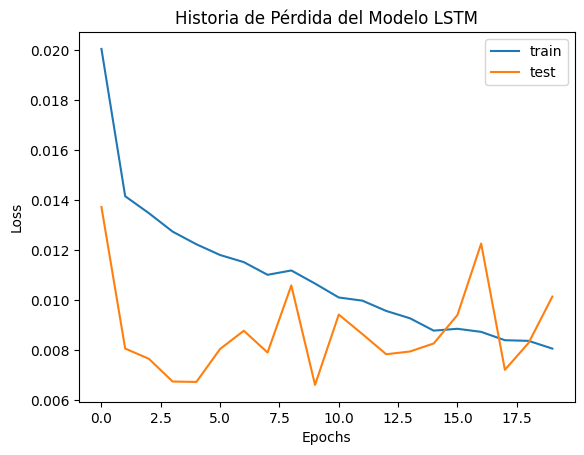

In [20]:
# Evaluación
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Historia de Pérdida del Modelo LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Realizar predicciones
y_pred = model.predict(X_test)

# Asegurarse de que y_test está en la forma adecuada si aún no se ha hecho
y_test = y_test.flatten()  # Esto es necesario solo si y_test no está ya en forma plana

45/45 [==============================] - 1s 4ms/step


In [23]:
column_index = df_auser.columns.get_loc("Depth_to_Groundwater_SAL")

# Prepara matrices completas con ceros para la inversión de escala
y_pred_full = np.zeros((len(y_pred), len(df_auser.columns)))  # Crea una matriz completa de ceros
y_test_full = np.zeros((len(y_test), len(df_auser.columns)))  # Crea una matriz completa de ceros

# Inserta las predicciones y los valores reales en la posición correcta
y_pred_full[:, column_index] = y_pred.ravel()  # Asegúrate de que y_pred es un array plano
y_test_full[:, column_index] = y_test.ravel()  # Asegúrate de que y_test es un array plano

# Aplicar la transformación inversa
y_pred_rescaled = scaler.inverse_transform(y_pred_full)[:, column_index]
y_test_rescaled = scaler.inverse_transform(y_test_full)[:, column_index]

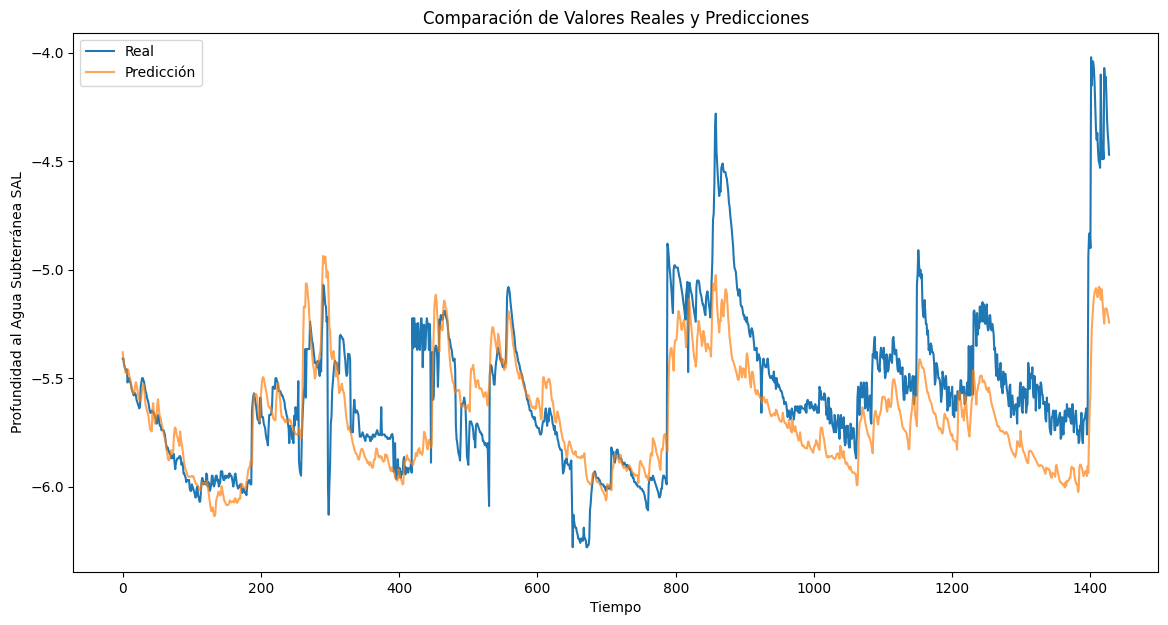

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Real')
plt.plot(y_pred_rescaled, label='Predicción', alpha=0.7)
plt.title('Comparación de Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Profundidad al Agua Subterránea SAL')
plt.legend()
plt.show()

## ANÁLISIS DE RESULTADOS

### Correlación Visual entre Predicciones y Valores Reales:
#### Observación: 
Las predicciones parecen seguir de cerca la tendencia general y los ciclos de los valores reales. Esto indica que el modelo ha aprendido efectivamente algunas de las dinámicas subyacentes de la serie temporal.
#### Implicación: 
El modelo puede capturar tanto la tendencia como la periodicidad de la serie, lo cual es esencial para tareas de predicción en series temporales con características estacionales.

### Rendimiento en Picos y Valles:
#### Observación: 
Hay momentos, especialmente en picos y valles pronunciados, donde las predicciones no coinciden perfectamente con los valores reales, indicando posibles problemas con fenómenos extremos o cambios abruptos en los datos.

#### Implicación: 
Esto puede deberse a la naturaleza de la serie temporal que podría incluir ruido o eventos no capturados totalmente por el modelo. Considera explorar modelos más complejos o agregar más características explicativas si es posible.

### Errores en el Predicción:
#### Observación: 
Hacia el final del gráfico, se observa una desviación considerable entre las predicciones y los valores reales. Esto podría indicar que el modelo no se generaliza bien hacia el final del conjunto de prueba.
#### Implicación: 
Este tipo de error podría deberse a cambios en el comportamiento de la serie temporal que no fueron capturados durante el entrenamiento. En el EDA se observó un aumento abrupto de los valores al final de la serie.

In [25]:
model_path = '../models/LSTM.h5'

# Guardar el modelo
model.save(model_path)
print("Modelo guardado correctamente en:", model_path)

c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modelo guardado correctamente en: ../models/LSTM.h5


In [31]:
def lstm_model(params):
    model = Sequential()
    model.add(LSTM(int(params['units']), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=params['learning_rate']))
    
    #Entrenamiento
    history = model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']),
                        verbose=0, validation_split=0.2)
    
    # Los mejores modelos deben tener el menor loss de validación
    val_loss = np.amin(history.history['val_loss'])
    return {'loss': val_loss, 'status': STATUS_OK}

space = {
    'units': hp.quniform('units', 50, 400, 10),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'epochs': hp.quniform('epochs', 5, 50, 1),
    'batch_size': hp.quniform('batch_size', 16, 128, 1)
}

trials = Trials()
best = fmin(lstm_model, space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Mejores hiperparámetros encontrados:", best)

100%|██████████| 50/50 [1:12:48<00:00, 87.37s/trial, best loss: 0.004920550622045994] 
Mejores hiperparámetros encontrados: {'batch_size': 69.0, 'dropout': 0.08007239525006084, 'epochs': 14.0, 'learning_rate': 0.0005295265272424669, 'units': 370.0}


In [33]:
model_path = '../models/LSTM_best_model.h5'

# Guardar el modelo
model.save(model_path)
print("Modelo guardado correctamente en:", model_path)

Modelo guardado correctamente en: ../models/LSTM_best_model.h5


In [34]:
# Cargar el mejor modelo guardado
from keras.models import load_model
model = load_model(model_path)

# Evaluar el modelo en el conjunto de test
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)


45/45 [==============================] - 2s 6ms/step - loss: 0.0068
Test Loss: 0.006847832351922989


In [35]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Asegurarte de que y_test y y_pred son arrays planos para comparación
y_pred = y_pred.flatten()
y_test = y_test.flatten()

45/45 [==============================] - 1s 5ms/step


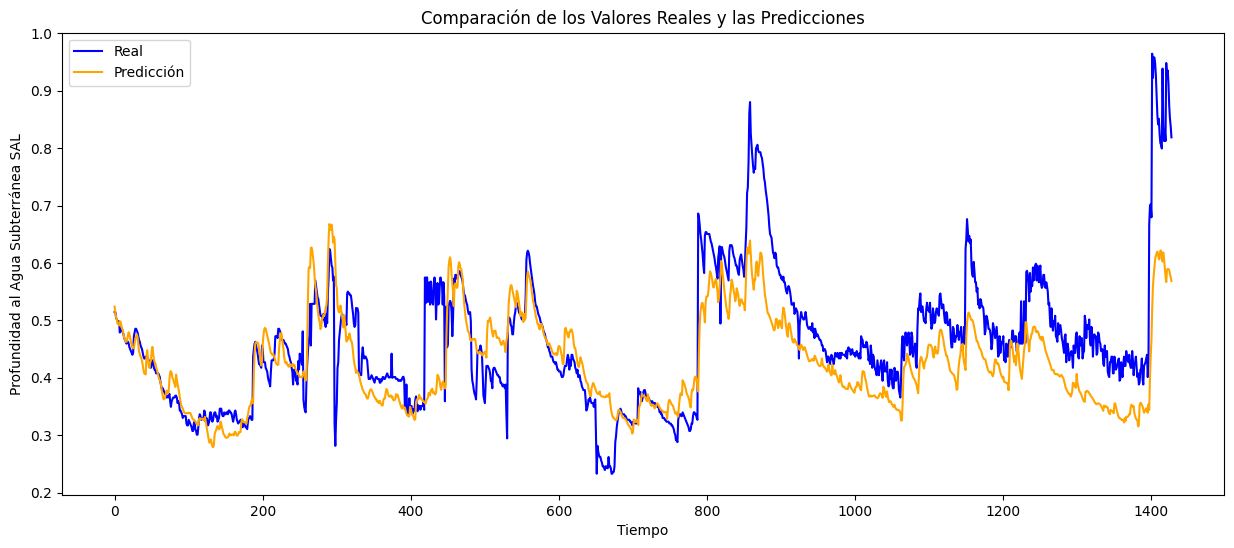

In [36]:
# Visualización
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='orange')
plt.title('Comparación de los Valores Reales y las Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Profundidad al Agua Subterránea SAL')
plt.legend()
plt.show()

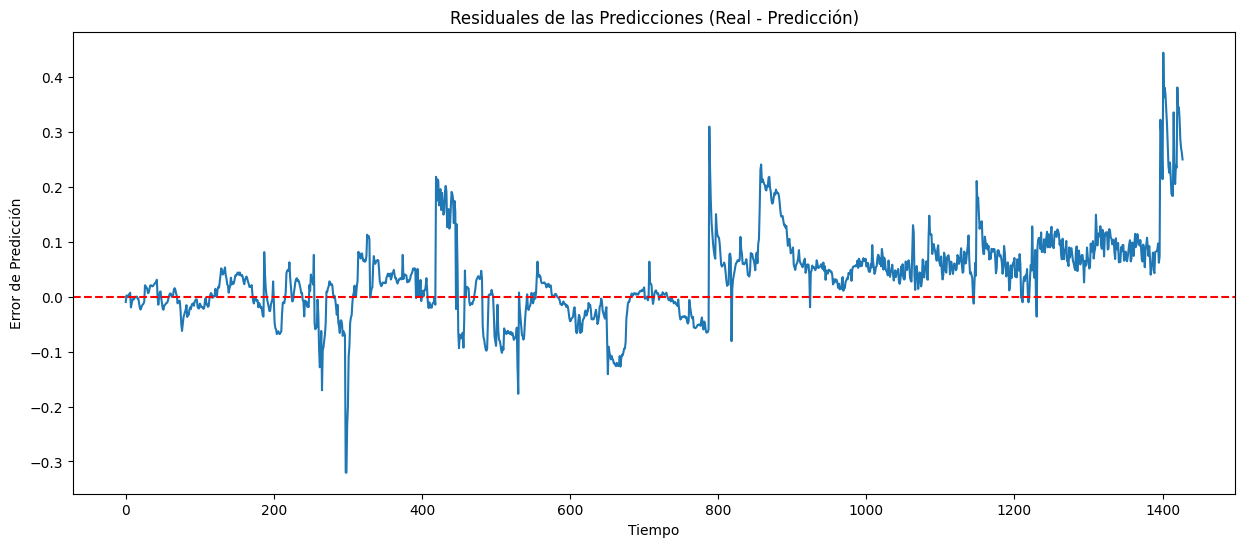

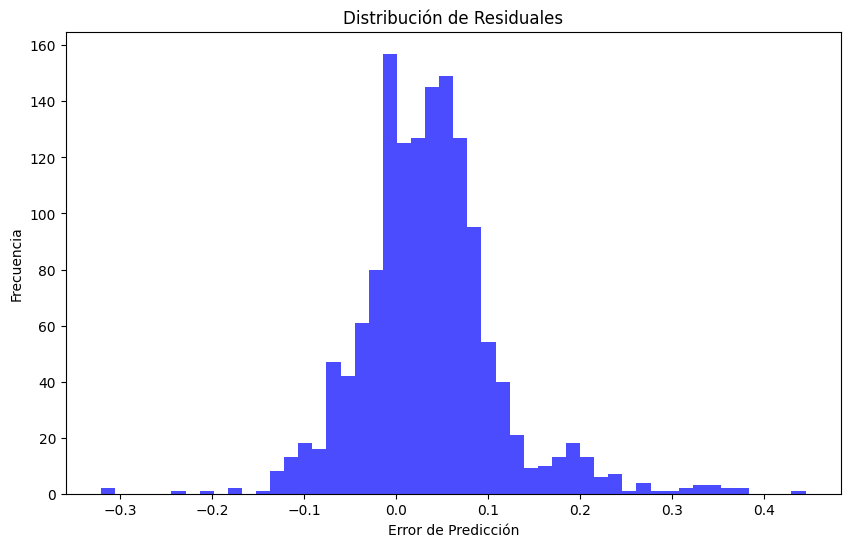

In [37]:
# Análisis de residuos
residuales = y_test - y_pred

plt.figure(figsize=(15, 6))
plt.plot(residuales)
plt.title('Residuales de las Predicciones (Real - Predicción)')
plt.xlabel('Tiempo')
plt.ylabel('Error de Predicción')
plt.axhline(y=0, color='r', linestyle='--')  # Línea en y=0 para referencia
plt.show()

# Histograma de residuales
plt.figure(figsize=(10, 6))
plt.hist(residuales, bins=50, alpha=0.7, color='blue')
plt.title('Distribución de Residuales')
plt.xlabel('Error de Predicción')
plt.ylabel('Frecuencia')
plt.show()

# REsiduales de las predicciones
### Centrado en Cero: 
La línea de error parece estar oscilando alrededor de cero, lo cual es un buen indicio. Esto sugiere que no hay un sesgo sistemático en las predicciones del modelo; es decir, el modelo no tiende sistemáticamente a sobreestimar ni subestimar la profundidad del agua subterránea.
### Variabilidad del Error: 
A lo largo de la serie temporal, los errores varían significativamente en magnitud, con algunos picos prominentes. Estos picos podrían indicar momentos en los cuales el modelo falla en capturar algunas dinámicas específicas de los datos.

## Análisis Detallado
### Consistencia de los Errores
La consistencia del error a lo largo del tiempo es relativamente estable, aunque con picos esporádicos. Esto podría indicar que el modelo se comporta bien bajo condiciones normales pero tiene dificultades en situaciones anómalas o durante cambios abruptos en los datos subyacentes.

### Distribución de los Errores
Aunque la mayoría de los residuales están cerca de cero, la presencia de errores grandes podría ser una señal de preocupación. Es importante analizar más a fondo qué está causando estos picos. Podrían ser el resultado de valores atípicos en los datos, cambios estacionales no capturados por el modelo, o eventos específicos que afectan los niveles de agua subterránea.

## Posibles Mejoras
### Reducción de Picos: 
Considerar técnicas de preprocesamiento adicionales para manejar mejor los valores atípicos o aumentar la robustez del modelo, como el escalado robusto de los datos o la incorporación de capas adicionales que puedan manejar mejor las fluctuaciones abruptas.

### Análisis Temporal: 
Revisar los períodos de tiempo correspondientes a los grandes picos de error para entender mejor si coinciden con eventos externos o cambios en las tendencias de los datos.

# Histograma de Residuales
## Observaciones Generales:
### Forma de la Distribución:
La distribución parece tener una forma ligeramente sesgada hacia la derecha, con una mayor concentración de errores menores a cero. Esto indica que el modelo tiende a subestimar los valores reales en muchos casos.
### Concentración de Residuales:
Hay una clara concentración de residuales alrededor de cero, lo que sugiere que en la mayoría de los casos, el modelo realiza predicciones relativamente precisas.
Sin embargo, la cola hacia la derecha más pesada sugiere que hay varios casos donde las predicciones exceden significativamente el valor real.

## Implicaciones:
### Sesgo en el Modelo:
El ligero sesgo hacia predicciones subestimadas podría indicar una característica sistemática del modelo que no se ajusta completamente a algunos aspectos de los datos. Este podría ser un área de enfoque para futuras mejoras en el modelo, como ajustar el preprocesamiento de los datos o revisar las características de entrada.

### Robustez y Estabilidad:
La presencia de errores más grandes (residuales altos positivos) puede afectar la robustez del modelo. Puede ser beneficioso investigar más a fondo estos casos para entender si corresponden a condiciones atípicas en los datos o si hay patrones específicos que el modelo consistentemente no logra aprender.

In [38]:
# Métricas
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)

Root Mean Squared Error (RMSE): 0.08275163141620319
Mean Absolute Error (MAE): 0.05992150446021228
Mean Absolute Percentage Error (MAPE): 0.12341790050905249


c:\Users\Andrés\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Los resultados mostrados sugieren que el modelo está funcionando razonablemente bien con un RMSE de 0.08275, un MAE de 0.05992 y un MAPE de 0.12341

In [39]:
# Correlación de Predicciones
correlation_matrix = np.corrcoef(y_test, y_pred)
correlation = correlation_matrix[0, 1]
print(f"Correlación entre valores reales y predicciones: {correlation:.2f}")

Correlación entre valores reales y predicciones: 0.76


La correlación de 0.76 entre los valores reales y las predicciones es bastante alta, lo que indica que el modelo puede capturar eficazmente la tendencia y variabilidad de los datos.

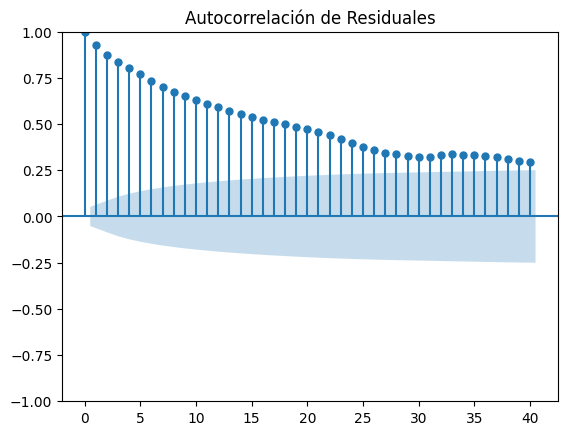

In [40]:
# Autocorrelación de Residuales
plot_acf(residuales, lags=40)
plt.title('Autocorrelación de Residuales')
plt.show()

## Interpretación del Gráfico de Autocorrelación
### Presencia de Información no Capturada: 
La autocorrelación significativa en los residuales sugiere que el modelo LSTM no está capturando toda la información temporal presente en la serie. Esto puede ser un indicativo de que hay dinámicas subyacentes o patrones recurrentes en los datos que el modelo actual no ha aprendido completamente.

### Modelo Subespecificado: 
Podría ser necesario revisar la arquitectura del modelo, tal como aumentar el número de capas LSTM, ajustar el número de unidades por capa, o incluso considerar la integración de otras formas de capas recurrentes que pueden captar mejor las dependencias a largo plazo.

### Potencial para Mejora: 
Este patrón sugiere que podríamos mejorar el modelo ajustando los hiperparámetros o explorando diferentes configuraciones de la arquitectura del modelo para tratar de capturar mejor la autocorrelación observada.